In [18]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


In [19]:
df = pd.read_csv("../mammografie.csv")
df = df.dropna(subset=['Severity', 'X', 'Y', 'Radius'])
#Nuova colonna Severity dove 0 è benigno e 1 è maligno
df['Target'] = df['Severity'].map({'B': 0, 'M': 1})

df['X'] = pd.to_numeric(df['X'], errors='coerce')
df['Y'] = pd.to_numeric(df['Y'], errors='coerce')
df = df.dropna(subset=['X', 'Y'])
df['ID_Num'] = df['ID'].str.extract(r'(\d+)').astype(int)

Aggiunta feture per migliorare il modello

In [20]:
#area del tumore
df['Area'] = np.pi * (df['Radius'] ** 2)
#distanza dal centro dell'immagine
df['DistanzaCentro'] = np.sqrt((df['X'] - 512)**2 + (df['Y'] - 512)**2)
#df['Lato'] = df['ID_Num'].apply(lambda n: 'sinistro' if n % 2 == 1 else 'destro')
#df['X_corr'] = df.apply(lambda row: 1024 - row['X'] if row['Lato'] == 'sinistro' else row['X'], axis=1)
#df['LatoBinary'] = df['Lato'].map({'sinistro': 0, 'destro': 1})
df['RadiusBin'] = pd.qcut(df['Radius'], q=5, labels=['XS', 'S', 'M', 'L', 'XL'])

def quadrante(row):
    if row['X'] < 512 and row['Y'] < 512:
        return 'Q0'
    elif row['X'] >= 512 and row['Y'] < 512:
        return 'Q1'
    elif row['X'] < 512 and row['Y'] >= 512:
        return 'Q2'
    else:
        return 'Q3'
df['Quadrante'] = df.apply(quadrante, axis=1)
#df['Quadrante_Lato'] = df['Quadrante'] + '_' + df['Lato']

# SELEZIONE FEATURE 
X = df[['Tissue', 'Class', 'Area', 'Quadrante', 'RadiusBin', 'DistanzaCentro']]
y = df['Target']

In [21]:

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Preprocessing
numeric_features = ['Area', 'DistanzaCentro']
categorical_features = ['Tissue', 'Class', 'Quadrante', 'RadiusBin']

preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

# Classificatore 
svm_model = SVC(probability=True, random_state=42)

svm_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', svm_model)
])


In [22]:
from matplotlib import pyplot as plt

svm_pipeline.fit(X_train, y_train)

# Predizioni sul set di test
y_pred = svm_pipeline.predict(X_test)
print("Previsioni completate.")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Benigno', 'Maligno']))


Addestramento del modello SVC...
Addestramento completato.
Effettuando previsioni sul set di test...
Previsioni completate.
🎯 Accuracy: 0.75
📊 Confusion Matrix:
[[10  4]
 [ 2  8]]
📋 Classification Report:
              precision    recall  f1-score   support

     Benigno       0.83      0.71      0.77        14
     Maligno       0.67      0.80      0.73        10

    accuracy                           0.75        24
   macro avg       0.75      0.76      0.75        24
weighted avg       0.76      0.75      0.75        24



ANALISI IMPORTANZA FEATURE


--- Analisi dell'Importanza delle Feature (Permutation Importance) ---

Report Permutation Importance:
           Feature  Importance_Mean  Importance_Std
0             Area         0.166667        0.058926
12    Quadrante_Q1         0.133333        0.058333
19    RadiusBin_XS         0.125000        0.072169
1   DistanzaCentro         0.066667        0.059512
18    RadiusBin_XL         0.050000        0.025000
7       Class_CALC         0.045833        0.029167
13    Quadrante_Q2         0.045833        0.029167
2         Tissue_D         0.041667        0.026352
3         Tissue_F         0.033333        0.016667
6       Class_ASYM         0.029167        0.026680
15     RadiusBin_L         0.025000        0.042492
11    Quadrante_Q0         0.025000        0.027639
16     RadiusBin_M         0.020833        0.020833
8       Class_CIRC         0.016667        0.020412
5       Class_ARCH         0.008333        0.016667
9       Class_MISC         0.004167        0.012500
17     Radiu

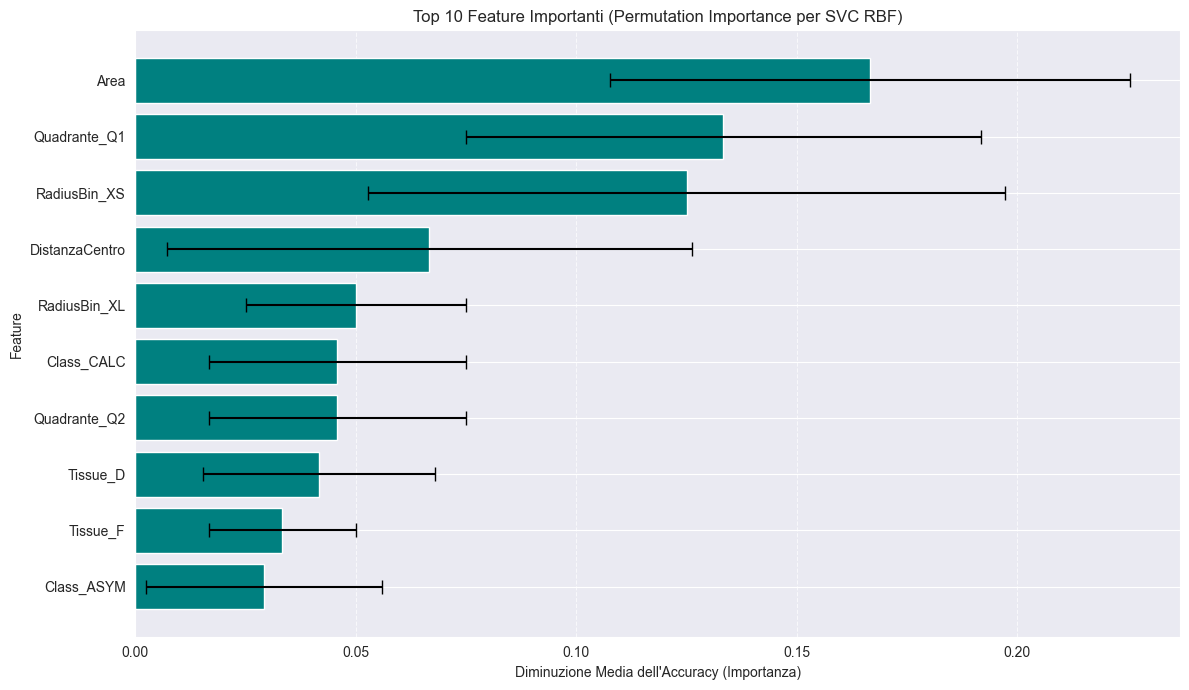

In [23]:
from sklearn.inspection import permutation_importance

X_test_transformed = svm_pipeline.named_steps['preprocessor'].transform(X_test)
ohe_feature_names = svm_pipeline.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_features)
all_transformed_feature_names = numeric_features + list(ohe_feature_names)

result = permutation_importance(
    estimator=svm_pipeline.named_steps['classifier'], 
    X=X_test_transformed,                              
    y=y_test,
    scoring='accuracy',                               
    n_repeats=10,                                       
    random_state=42,
    n_jobs=-1                                         
)

feature_importance_df = pd.DataFrame({
    'Feature': all_transformed_feature_names,
    'Importance_Mean': result.importances_mean,
    'Importance_Std': result.importances_std
})

feature_importance_df = feature_importance_df.sort_values(by='Importance_Mean', ascending=False)

print(feature_importance_df)

plt.figure(figsize=(12, 7))
plt.barh(feature_importance_df['Feature'].head(10), feature_importance_df['Importance_Mean'].head(10),
         xerr=feature_importance_df['Importance_Std'].head(10), capsize=5, color='teal')
plt.xlabel("Diminuzione Media dell'Accuracy (Importanza)")
plt.ylabel("Feature")
plt.title("Top 10 Feature Importanti (Permutation Importance per SVC RBF)")
plt.gca().invert_yaxis() 
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
